In [4]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import madmom
import mir_eval
from modules.analysis_funcs import aubio_peakpicker_do, aubio_postprocessing
from analyze_detection import evaluate

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from datasets import Dataset
ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")
ds_test = Dataset("slurtest_test")

#audio_fnames = ds0.get_audio_paths() + ds1.get_audio_paths()
audio_fnames = ds_test.get_audio_paths()
label_fnames = ds_test.get_annotation_paths()
audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]


/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [3]:
sigg = madmom.audio.signal.SignalProcessor(num_channels=1)
frame = madmom.audio.signal.FramedSignalProcessor(frame_size=256, hop_size=441)
stft = madmom.audio.stft.STFTProcessor()
proc = madmom.processors.SequentialProcessor([sigg, frame, stft])

In [5]:
SHIFT = 5
THRES = 0.5
TOLS = np.arange(0.01,0.06,0.01)
HOP = 441



In [7]:
# With SonicVisualizer HFC onsets

TOL = 0.025
fs = []
rs = []
ps = []
CD_list = []
FN_list = []
FP_list = []
for r in np.arange(len(audio_fnames)):
    rec_name = os.path.basename(audio_fnames[r])
    #print(rec_name)
    spect = proc(audio_fnames[r])
    peaks = np.genfromtxt(fname="datasets/slurtest_add/hfc2_detections/" + rec_name[:-4] + ".csv")
    [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
    CD_list.append(CD)
    FN_list.append(FN)
    FP_list.append(FP)
    scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
    #print(scores["F-measure"], scores["Recall"], scores["Precision"])
    fs.append(scores["F-measure"])
    ps.append(scores["Precision"])
    rs.append(scores["Recall"])
print(TOL)
print("Mean F: ", np.mean(fs))
print("Mean P: ", np.mean(ps))
print("Mean R: ", np.mean(rs))

0.025
Mean F:  0.69486027893258
Mean P:  0.7966889883167787
Mean R:  0.6385803762314544


In [8]:
print("Total F: ", "{:.2f}".format(100*np.sum(CD_list)/(np.sum(CD_list)+.5*(np.sum(FP_list) + np.sum(FN_list)))))
print("Total P: ", "{:.2f}".format(100*np.sum(CD_list)/(np.sum(CD_list)+np.sum(FP_list))))
print("Total R: ", "{:.2f}".format(100*np.sum(CD_list)/(np.sum(CD_list)+np.sum(FN_list))))

Total F:  72.70
Total P:  81.03
Total R:  65.92


In [9]:

fss = []
for TOL in TOLS:
    fs = []
    rs = []
    ps = []
    CD_list = []
    FN_list = []
    FP_list = []
    for r in np.arange(len(audio_fnames)):
        rec_name = os.path.basename(audio_fnames[r])
        #print(rec_name)
        #spect = proc(audio_fnames[r])
        #hfc = madmom.features.onsets.high_frequency_content(np.abs(spect))
        #onehot, out = aubio_peakpicker_do(hfc, threshold=THRES)
        #peaks = (np.where(onehot==1)[0]-SHIFT)*HOP/sample_rates[r]
        peaks = np.genfromtxt(fname="datasets/slurtest_add/hfc2_detections/" + rec_name[:-4] + ".csv")
        [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
        CD_list.append(CD)
        FN_list.append(FN)
        FP_list.append(FP)
        scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
        #print(scores["F-measure"], scores["Recall"], scores["Precision"])
        fs.append(scores["F-measure"])
        ps.append(scores["Precision"])
        rs.append(scores["Recall"])
    print(TOL)
    print("Mean F: ", np.mean(fs))
    print("Mean P: ", np.mean(ps))
    print("Mean R: ", np.mean(rs))
    fss.append(np.mean(fs))

0.01
Mean F:  0.3891553596449332
Mean P:  0.45356731110662313
Mean R:  0.3519304423029404
0.02
Mean F:  0.6358880374416361
Mean P:  0.7274769783525139
Mean R:  0.5852347686423652
0.03
Mean F:  0.7198238117917328
Mean P:  0.8242778315524731
Mean R:  0.6616532912194756
0.04
Mean F:  0.7309223123643593
Mean P:  0.8382952683353515
Mean R:  0.6711975322568515
0.05
Mean F:  0.7347684662105132
Mean P:  0.8425325564709447
Mean R:  0.674718659017415


In [10]:
np.save(file="results/computed/hfc_time_prec.npy", arr=fss)


Text(0.5, 0, 'Tolerance window [ms]')

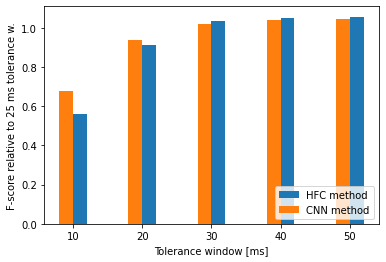

In [12]:
time_prec = np.array([np.load(file="results/computed/hfc_time_prec.npy"),np.load(file="results/computed/cnn_time_prec.npy")])
plt.bar(
    x=np.arange(10,60,10),
    height=time_prec.transpose()[:,0]/0.6948,
    align='edge',
    width = 2.0
)
plt.bar(
    x=np.arange(10,60,10),
    height=time_prec.transpose()[:,1]/0.8692,
    width=-2.0,
    align='edge'
)
plt.legend(["HFC method", "CNN method"], loc="lower right")
plt.ylabel("F-score relative to 25 ms tolerance w.")
plt.xlabel("Tolerance window [ms]")



In [15]:
100*time_prec.transpose()[:,1]/0.8692

array([ 67.63413655,  93.96500603, 101.94686941, 103.9372538 ,
       104.71221762])

In [17]:
import pandas as pd
print(
    
    pd.DataFrame(time_prec,
    columns=np.arange(10,60,10),
    index=["HFC", "CNN"],).to_latex()
)

\begin{tabular}{lrrrrr}
\toprule
{} &        10 &        20 &        30 &        40 &        50 \\
\midrule
HFC &  0.389155 &  0.635888 &  0.719824 &  0.730922 &  0.734768 \\
CNN &  0.587876 &  0.816744 &  0.886122 &  0.903423 &  0.910159 \\
\bottomrule
\end{tabular}



/var/folders/hb/mg80hj2s1lqdy7x5r3zdlk0m0000gp/T/ipykernel_14807/1124330622.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(time_prec,


In [26]:
print("Total F: ", "{:.2f}".format(100*np.sum(CD_list)/(np.sum(CD_list)+.5*(np.sum(FP_list) + np.sum(FN_list)))))
print("Total P: ", "{:.2f}".format(100*np.sum(CD_list)/(np.sum(CD_list)+np.sum(FP_list))))
print("Total R: ", "{:.2f}".format(100*np.sum(CD_list)/(np.sum(CD_list)+np.sum(FN_list))))

Total F:  60.42
Total P:  74.53
Total R:  50.80


In [23]:
THRESS = [0.001,0.01,0.05,0.1,0.15,0.2,0.5,0.9]
cds = np.zeros((len(THRESS), len(audio_fnames)))
fps = np.zeros((len(THRESS), len(audio_fnames)))
fns = np.zeros((len(THRESS), len(audio_fnames)))
tns = np.zeros((len(THRESS), len(audio_fnames)))

In [17]:
positives = np.zeros(len(audios))
negatives = np.zeros(len(audios))
for a, onsets in enumerate(onset_schedules):
    positives[a] = np.sum(onsets)
    negatives[a] = len(onsets) - np.sum(onsets)
    

In [28]:
for a, (fname, audio, onsets, sr) in enumerate(zip(audio_fnames, audios, onset_schedules, sample_rates)):
    
    for t, THRES in enumerate(THRESS):
        spect = proc(fname)
        hfc = madmom.features.onsets.high_frequency_content(np.abs(spect))
        onehot, out = aubio_peakpicker_do(hfc, threshold=THRES)
        peaks = (np.where(onehot==1)[0]-SHIFT)*HOP/sr
        [CD,FN,FP,doubles,merged] = evaluate(onsets, peaks, tol_sec=TOL)
        cds[t, a] = CD
        fps[t, a] = FP
        fns[t, a] = FN
        tns[t, a] = (len(onehot)-onehot.sum()) - FN
    print(fname)
    print(cds[:,a]/(cds[:,a]+0.5*fps[:,a]+fns[:,a]))


datasets/initslurtest_vn/initslurtest_vn_wav/slurtest01.wav
[0.42033898 0.43971631 0.52863436 0.64864865 0.75159236 0.7862069
 0.46153846 0.07874016]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest02.wav
[0.41696113 0.43703704 0.5462963  0.65909091 0.7037037  0.73333333
 0.544      0.1300813 ]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest03.wav
[0.42553191 0.44280443 0.55299539 0.65217391 0.72392638 0.73076923
 0.43076923 0.09677419]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest04.wav
[0.54744526 0.57034221 0.65777778 0.76041667 0.79545455 0.80239521
 0.36601307 0.10526316]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest05.wav
[0.36812144 0.38645418 0.46568627 0.5497076  0.64111498 0.6741573
 0.65420561 0.21463415]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest06.wav
[0.66465257 0.67484663 0.71317829 0.70906949 0.68203883 0.63840399
 0.37569061 0.10496454]
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest07.wav
[0.64886251 0.66869919 0.69146608 0.

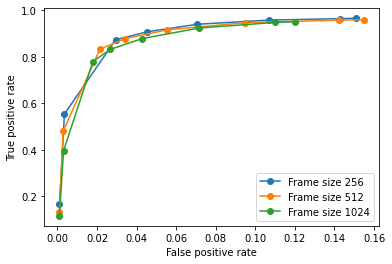

In [7]:
fscores = []
for win_size in [256, 512, 1024]:
    cds = np.load("results/hfc-eval-220422/hfc_AB_w"+ str(win_size)+"_tuning_cds.npy")
    fns = np.load("results/hfc-eval-220422/hfc_AB_w"+ str(win_size)+"_tuning_fns.npy")
    fps = np.load("results/hfc-eval-220422/hfc_AB_w"+ str(win_size)+"_tuning_fps.npy")
    tns = np.load("results/hfc-eval-220422/hfc_AB_w"+ str(win_size)+"_tuning_tns.npy")
    tpr = cds.sum(1)/(cds.sum(1)+fns.sum(1))
    fpr = fps.sum(1)/(fps.sum(1)+tns.sum(1))
    fscores.append(cds.sum(1)/(cds.sum(1)+0.5*fps.sum(1)+0.5*fns.sum(1)))
    plt.plot(fpr, tpr, '-o')

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Frame size " + str(w) for w in [256, 512, 1024]])

In [18]:
import pandas as pd
print(pd.DataFrame(
    100*np.array(fscores),
    columns = [0.001,0.01,0.05,0.1,0.15,0.2,0.5,0.9],
    index = [256, 512, 1024]
).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  0.001 &  0.010 &  0.050 &  0.100 &  0.150 &  0.200 &  0.500 &  0.900 \\
\midrule
256  &  25.27 &  26.27 &  31.98 &  40.85 &  50.13 &  58.58 &  65.58 &  27.20 \\
512  &  27.37 &  28.76 &  36.35 &  46.96 &  56.14 &  63.32 &  60.30 &  22.24 \\
1024 &  29.42 &  31.11 &  40.03 &  50.36 &  58.59 &  63.48 &  52.22 &  19.82 \\
\bottomrule
\end{tabular}



/var/folders/hb/mg80hj2s1lqdy7x5r3zdlk0m0000gp/T/ipykernel_2930/1535588750.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(


In [5]:
fscores

NameError: name 'tns' is not defined

In [29]:
np.save(file="results/hfc-eval-220422/hfc_AB_w1024_tuning_tns.npy", arr=tns)

In [ ]:
np.load(file="results/hfc-eval-220422/hfc_AB_w512_tuning_tns.npy")